Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Diccionario cargado desde el archivo JSON.
Lote 1: Imágenes: torch.Size([32, 3, 128, 128]), Targets: torch.Size([32])
Lote 2: Imágenes: torch.Size([32, 3, 128, 128]), Targets: torch.Size([32])
Época 1: Mejor modelo guardado con pérdida de validación 0.5526
Época 1/100, Pérdida Entrenamiento: 0.5370, Pérdida Validación: 0.5526
Época 2: Mejor modelo guardado con pérdida de validación 0.5449
Época 2/100, Pérdida Entrenamiento: 0.5283, Pérdida Validación: 0.5449
Época 3: Mejor modelo guardado con pérdida de validación 0.5382
Época 3/100, Pérdida Entrenamiento: 0.5232, Pérdida Validación: 0.5382
Época 4: Mejor modelo guardado con pérdida de validación 0.5316
Época 4/100, Pérdida Entrenamiento: 0.5182, Pérdida Validación: 0.5316
Época 5: Mejor modelo guardado con pérdida de validación 0.5252
Época 5/100, Pérdida Entrenamiento: 0.5125, Pérdida Validación: 0.5252
Épo

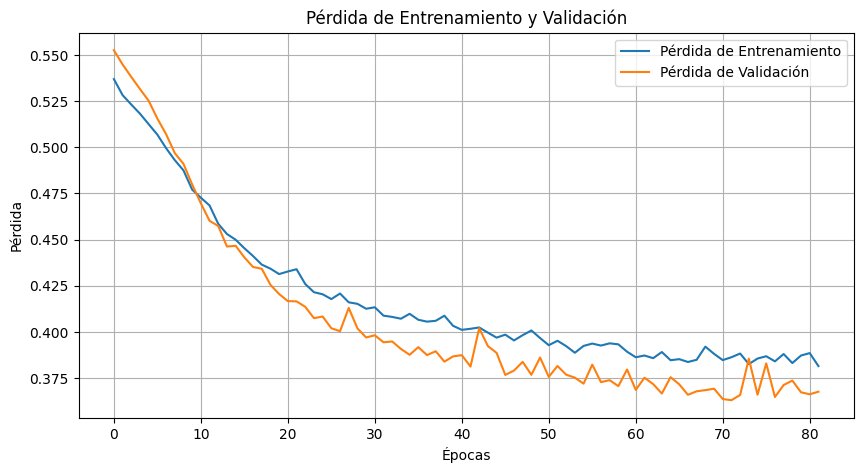

Mejor modelo guardado en /content/drive/My Drive/Colab Notebooks/Proyecto/best_model_cnn.pth


In [4]:
from google.colab import drive
import os
from PIL import Image
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Montar Google Drive
drive.mount('/content/drive')


project_path = "/content/drive/My Drive/Colab Notebooks/Proyecto"

# Cargar el diccionario desde el archivo JSON
with open(os.path.join(project_path, 'id_to_target.json'), 'r') as f:
    subfolder_to_target = json.load(f)
print("Diccionario cargado desde el archivo JSON.")


image_folder_path = os.path.join(project_path, "extracted_files")

# Transformaciones para las imágenes
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

# Dataset
class ImageDataset(Dataset):
    def __init__(self, image_folder, subfolder_to_target, transform=None):
        self.image_folder = image_folder
        self.subfolder_to_target = subfolder_to_target
        self.transform = transform
        self.image_paths = []
        self.targets = []

        # asociar imágenes con etiquetas
        for root, dirs, files in os.walk(image_folder):
            subfolder_name = os.path.basename(root)
            target = self.subfolder_to_target.get(subfolder_name, None)
            if target is not None:
                for file_name in files:
                    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        file_path = os.path.join(root, file_name)
                        self.image_paths.append(file_path)
                        self.targets.append(target)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        target = self.targets[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(target, dtype=torch.float32)


custom_dataset = ImageDataset(image_folder_path, subfolder_to_target, transform=image_transforms)
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Dividir el dataset en entrenamiento, validación y prueba
dataset_size = len(custom_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

#  DataLoaders para cada split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for batch_idx, (images, targets) in enumerate(train_loader):
    print(f"Lote {batch_idx + 1}: Imágenes: {images.shape}, Targets: {targets.shape}")
    if batch_idx == 1: break

# Definir la arquitectura del modelo:
class FullyConvNet(nn.Module):
    def __init__(self):
        super(FullyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv_out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.global_pool(x)
        x = torch.tanh(self.conv_out(x))
        return x.squeeze()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullyConvNet().to(device)

# la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


epochs =100
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience, patience_counter = 10, 0
best_model_path = os.path.join(project_path, 'best_model_cnn.pth')



# Inicializar listas para almacenar las salidas y los targets durante el entrenamiento y la validación
train_outputs = []
val_outputs = []
train_targets = []
val_targets = []

# Entrenamiento
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)

        # Guardar las salidas del modelo para el entrenamiento
        train_outputs.append(outputs.cpu().detach().numpy())
        train_targets.append(targets.cpu().detach().numpy())
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            # Guardar las salidas del modelo para la validación
            val_outputs.append(outputs.cpu().detach().numpy())
            val_targets.append(targets.cpu().detach().numpy())
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # Media de las pérdidas
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Época {epoch+1}: Mejor modelo guardado con pérdida de validación {val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Deteniendo entrenamiento por Early Stopping...")
            break

    print(f"Época {epoch+1}/{epochs}, Pérdida Entrenamiento: {train_loss:.4f}, Pérdida Validación: {val_loss:.4f}")

# Guardar pérdidas y salidas
np.save(os.path.join(project_path, 'train_losses.npy'), train_losses)
np.save(os.path.join(project_path, 'val_losses.npy'), val_losses)

# Guardar las salidas del modelo durante el entrenamiento
train_outputs = np.concatenate(train_outputs, axis=0)
np.save(os.path.join(project_path, 'train_outputs_cnn.npy'), train_outputs)

# Guardar las salidas del modelo durante la validación
val_outputs = np.concatenate(val_outputs, axis=0)
np.save(os.path.join(project_path, 'val_outputs_cnn.npy'), val_outputs)

# Guardar los targets de entrenamiento
train_targets = np.concatenate(train_targets, axis=0)
np.save(os.path.join(project_path, 'train_targets_cnn.npy'), train_targets)

# Guardar los targets de validación
val_targets = np.concatenate(val_targets, axis=0)
np.save(os.path.join(project_path, 'val_targets_cnn.npy'), val_targets)

# Grafico
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(val_losses, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()
plt.grid()
plt.show()

# Ver si el modelo fue guardado
if os.path.exists(best_model_path):
    print(f"Mejor modelo guardado en {best_model_path}")
else:
    print("Error")


In [7]:
# Cargar el mejor modelo guardado
model.load_state_dict(torch.load(best_model_path))
model.eval()  #  modo evaluación

#la función de pérdida
criterion = nn.MSELoss()

#  almacenar las salidas y los targets
test_outputs, test_targets = [], []

# Evaluación test
test_loss = 0.0
with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)


        outputs = model(images)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Aplanar las salidas
        test_outputs.append(outputs.cpu().detach().numpy().flatten())
        test_targets.append(targets.cpu().detach().numpy().flatten())

# La media de la pérdida en test
test_loss /= len(test_loader)
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")


test_outputs = np.concatenate(test_outputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Guardar las salidas y etiquetas como archivos .npy
np.save(os.path.join(project_path, 'test_outputs_cnn.npy'), test_outputs)
np.save(os.path.join(project_path, 'test_targets_cnn.npy'), test_targets)

print("Las salidas y etiquetas guardadas en .npy")


<ipython-input-7-e00e3cc82a62>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Pérdida en el conjunto de prueba: 0.3304
Las salidas y etiquetas guardadas en .npy
